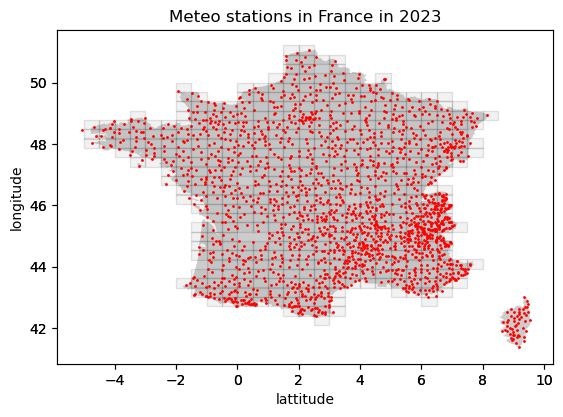

In [37]:
import pandas as pd
from shapely import Point, Polygon
from dataclasses import dataclass
import numpy as np
from matplotlib import animation
import os
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt   
import warnings 

warnings.filterwarnings("ignore")

def show_on_map(ax=None):
    france = gpd.read_file(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\EDA_1\Data\shapefile\FRA_adm0.shp")

    france.plot(ax=ax,alpha=0.4, color='grey')
    gdf_grid.plot(ax=ax, alpha = 0.1, color = "gray", edgecolor="black", )

xs, xe, ys, ye = -4.5, -5, 41.80357, 42.11314
grid = []
for j in range(0, 30):
    ys += 0.30357
    ye += 0.30357
    for i in range(0, 27):
        grid.append(Polygon(
            (Point(xs, ys), Point(xs, ye), Point(xe, ye), Point(xe, ys))
        ))
        xs += 0.5
        xe += 0.5
    xs = -4.5
    xe = -5

gdf_grid = gpd.GeoDataFrame({"geometry": grid})
fig = plt.figure(1)
ax1 = fig.subplots(1,1)
show_on_map(ax1)

os.chdir(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data")

df = pd.read_csv("2023_data.csv", sep=',')

df_position = df.drop_duplicates(subset=["NOM_USUEL"], keep='first')
all_lat = [lat for lat in df_position["LAT"]]
all_lon = [lon for lon in df_position["LON"]]

all_stations_points = [Point(all_lon[point], all_lat[point]) for point in range(0, len(all_lat))]
df_position["STATIONS_XY"] = all_stations_points

dico_station_position = dict(zip(df_position["NOM_USUEL"], df_position["STATIONS_XY"]))

@dataclass
class Station:
    nom : str
    position : Point
    def __init__(self, nom, position):
        self.nom = nom
        self.position = position

all_Stations = [Station(nom, position) for nom, position in dico_station_position.items()]
gdf_stations = gpd.GeoDataFrame(data={'geometry':all_stations_points})

@dataclass
class Case:
    id:int
    position:Polygon
    contain_station:list
    name_station:list
    neighbour:list
    frame_by_year:dict
    a : float
    b : float
    c : float
    slope : float
    intercept : float

    def __init__(self, id, position, contain_station, name_stations, frame, neighbour, frame_by_year, a, b, c, slope, intercept):
        self.id = id
        self.position = position
        self.contain_station = contain_station
        self.name_station = name_stations
        self.frame = frame
        self.neighbour = neighbour
        self.frame_by_year = frame_by_year
        self.a = a
        self.b = b
        self.c = c
        self.slope = slope
        self.intercept = intercept

all_Cases = [Case(index, polygone, [], [], pd.DataFrame(), [], {}, -1, -1, -1, -1, -1) for index, polygone in enumerate(grid)]

def contains_station(container):    
    return [station for station in all_Stations if station.position.within(container["geometry"].values)]

neighbour_rule_index = [27, -27, -1, +1, 28, -28, 26, -26]

for case in all_Cases:
    temp = gpd.GeoDataFrame({"geometry":[case.position]})
    case.contain_station = contains_station(temp) #check if the station is in the case

valid_id = [case.id for case in all_Cases]

all_Cases = [Case(case.id, case.position, case.contain_station,
                  [nom.nom for nom in case.contain_station], pd.DataFrame(),
                  [case.id+i for i in neighbour_rule_index if case.id+i in valid_id], {}, -1, -1, -1, -1, -1) for case in all_Cases if case.contain_station != []]

def show_on_map_2(ax=None):
    france = gpd.read_file(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\EDA_1\Data\shapefile\FRA_adm0.shp")

    france.plot(ax=ax,alpha=0.4, color='grey')
    gdf_grid.plot(ax=ax, alpha = 0.1, color = "gray", edgecolor="black", )
    gdf_stations.plot(ax=ax,color='red', markersize=1)

gdf_grid = gpd.GeoDataFrame({"geometry": [case.position for case in all_Cases]})

fig = plt.figure(1)
ax1 = fig.subplots(1,1)
ax1.set_ylabel("longitude")
ax1.set_xlabel("lattitude")
ax1.set_title("Meteo stations in France in 2023")
show_on_map_2(ax1)

In [38]:
def obsolete_func():
    for index, case in enumerate(all_Cases):
        temp = df.loc[df["NOM_USUEL"].isin(case.name_station)]
        temp = temp.drop("NOM_USUEL", axis=1)
        print(index)
        dates = temp["AAAAMMJJ"].unique()
        
        for date in dates:
            mean_temp = np.mean(temp["TNTXM"].loc[temp["AAAAMMJJ"]==date])
            temp["TNTXM"].loc[temp["AAAAMMJJ"]==date] = mean_temp
            temp = temp.drop_duplicates(subset=["AAAAMMJJ"], keep="first")

        case.frame = temp

obsolete_func()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
all_dates = sorted(df["AAAAMMJJ"].unique())
dico_dates_id = {val:str(i) for i, val in enumerate(all_dates)}

def to_csv(liste_square):
    for case in all_Cases:
        case.frame.to_csv(rf"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data\2023_dep\{case.id}.csv")

to_csv(all_Cases)

def date_labelling():
    os.chdir(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data\2023_dep")
    for file in os.listdir():
        temp = pd.read_csv(file, sep=',')
        temp["AAAAMMJJ"] = [int(dico_dates_id[ID]) for ID in temp["AAAAMMJJ"]]
        temp = temp.iloc[0:365, :]
        os.remove(file)
        temp.to_csv(str(file))

date_labelling()

In [40]:
os.chdir(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\weather_data\2023_dep")

def csv_to_square(liste_cases):
    for case in liste_cases:
        case.frame = pd.read_csv(f"{case.id}.csv", sep=',')

    return liste_cases

all_Cases = csv_to_square(all_Cases)
all_dates = [int(val) for val in dico_dates_id.values()]

dico_id_frame = {case.id:case.frame for case in all_Cases}
dico_id_position = {case.id:case.position for case in all_Cases}

In [53]:
biss = [2000, 2004, 2008, 2012, 2016, 2020]
tot = 0
intervals = []
for date in range(2000, 2023):
    if date in biss:
        intervals.append((tot, tot+365))
        tot+=366
    else:
        intervals.append((tot, tot+364))
        tot+=365

n_days = dict(zip(range(2023, 2024), intervals))

def date_frame_creation(cases : list)->list:
    for case in cases:
        new_frame = {key:pd.DataFrame() for key in range(2023,2024)}
        for col in new_frame.keys():
            start = n_days[col][0]
            end = n_days[col][1]
            new_frame[col] = case.frame[case.frame["AAAAMMJJ"].between(start, end)]

        case.frame_by_year = new_frame
    return cases
    
all_Cases = date_frame_creation(all_Cases)
print(all_Cases[0].frame_by_year)

{2023:      Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  NUM_POSTE  \
0               0        850791          8699        9406   66194002   
1               1        850792          8700        9407   66194002   
2               2        850793          8701        9408   66194002   
3               3        850794          8702        9409   66194002   
4               4        850795          8703        9410   66194002   
..            ...           ...           ...         ...        ...   
360           360        851151          9059        9766   66194002   
361           361        851152          9060        9767   66194002   
362           362        851153          9061        9768   66194002   
363           363        851154          9062        9769   66194002   
364           364        851155          9063        9770   66194002   

           LAT       LON  AAAAMMJJ  TNTXM  
0    42.399833  2.557833         0   13.8  
1    42.399833  2.557833         1   13.

In [105]:
def added_temp_calc(cases : list) -> pd.DataFrame:
    ad_temp_frame = pd.DataFrame(index=[str(i) for i in range(2023, 2024)], columns=[case.id for case in all_Cases])
    temp = 0
    for case in all_Cases:
        for year, frame in case.frame_by_year.items():
            dvpt_tresh = 16
            tresh_end =16
            add = 0
            for day in frame["AAAAMMJJ"].values:
                temp = frame["TNTXM"].loc[frame["AAAAMMJJ"]==day].values[0]
                if temp < 0 or temp-dvpt_tresh < 0 :
                    continue               

                if temp-dvpt_tresh > 0:
                    add += temp-dvpt_tresh
                if add > tresh_end :
                    if temp > 16 :
                        break
            if add < tresh_end :
                ad_temp_frame[case.id][str(year)] = -1
            else:
                ad_temp_frame[case.id][str(year)] = day - n_days[year][0]
    
    return ad_temp_frame

tresh_date = added_temp_calc(all_Cases)


for col in tresh_date.columns:
    if -1 in tresh_date[col].values:
        tresh_date = tresh_date.drop(col, axis=1)

tresh_date

,15,40,41,42,43,62,63,64,65,66,...,721,742,743,745,769,770,771,772,796,797
2023,146,177,118,110,118,117,117,170,152,146,...,157,160,161,158,167,161,161,157,163,162


In [106]:
for index, col in enumerate(tresh_date):
    all_Cases[index].slope = tresh_date.iat[0, index]

In [98]:
print(all_Cases[425].slope)

150


In [120]:
def gdf_case_correct(all_Cases):    
    gdf_cases = gpd.GeoDataFrame({"geometry":[case.position for case in all_Cases],
                                 "day":[case.slope for case in all_Cases]})
    
    gdf_cases = gdf_cases[gdf_cases["day"] > 0]
    gdf_cases = gdf_cases.iloc[0:427, :]


    return gdf_cases

gdf_cases = gdf_case_correct(all_Cases)

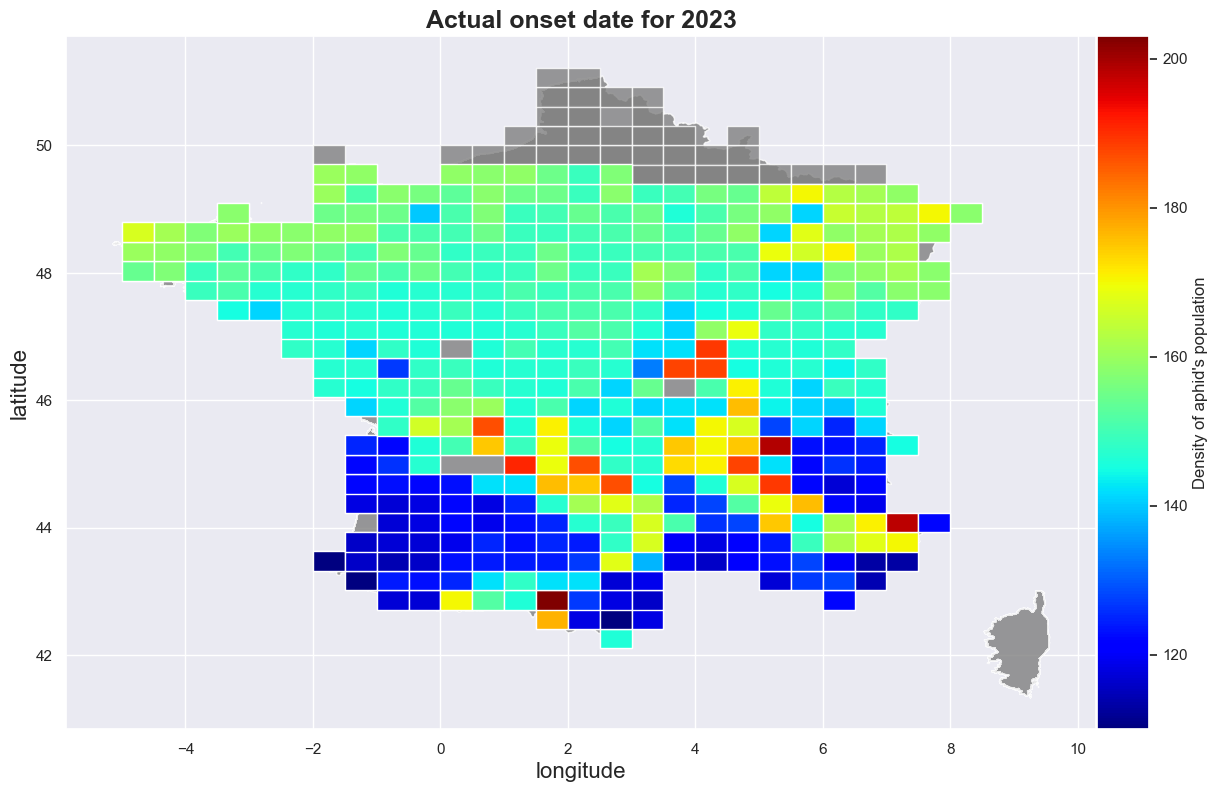

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme(rc={'figure.figsize':(16,9)})
def temp_2023_display(gdf_cases :gpd.GeoDataFrame, ax=plt.Axes):
    

    france = gpd.read_file(r"C:\Subpbiotech_cours\BT4\iGEM\Dry_lab\Model_prediction\EDA_1\Data\shapefile\FRA_adm0.shp")

    france.plot(ax=ax,alpha=0.8, color='grey')
    gdf_grid.plot(ax=ax, alpha = 0.8, color = "gray")
    gdf_cases.plot(ax=ax, alpha=1, column="day", legend=True, legend_kwds={"label":"Density of aphid's population", 
                                                                                            "orientation":"vertical"},
                                                                                cmap="jet", 
                                                                                cax = make_axes_locatable(ax).append_axes("right", 
                                                                                                                            size="5%", 
                                                                                                                            pad=0.01),
                                                                                vmin=110, 
                                                                                vmax=203)

fig = plt.figure(1)
ax1 = fig.subplots(1,1)
ax1.set_ylabel("latitude", fontsize=16)
ax1.set_xlabel("longitude", fontsize=16)
ax1.set_title("Actual onset date for 2023", fontweight="bold", size=18)
temp_2023_display(gdf_cases, ax1)

In [72]:
print(all_Cases[0].slope)

69
